In [1]:
# !pip install scipy

In [2]:
from scipy import ndimage
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
def fill_missing_data_laplace(
    field: np.ndarray,
    mask: np.ndarray,
    periodic_lon: bool = True
) -> np.ndarray:
    """
    Fill nans smoothly by solving a discrete Laplace problem over the wet domain.

    This is adapted from https://github.com/ACCESS-NRI/om3-scripts/blob/main/chlorophyll/chl_climatology_and_fill.py,
    which originally adapted from https://github.com/adcroft/interp_and_fill/blob/main/Interpolate%20and%20fill%20SeaWIFS.ipynb

    This implementation otherwise assumes a regular lat/lon grid tri-polar (WOA),
    hence tripolar topology is intentionally not handled here.

    Periodic boundary conditions are supported in longitude only (global configuration).
    For regional configurations, set periodic_lon=False is not implemented yet.
    """
    nj, ni = field.shape
    # Find the missing points to fill (nan in field but mask > 0)
    missing_mask = np.isnan(field) & (mask > 0)
    if not np.any(missing_mask):
        # no missing data to fill but also guarantee nans on dry cells
        return np.where(mask > 0, field, np.nan)

    # change nan to 0 for the sparse matrix construction
    work = np.where(np.isnan(field), 0.0, field)
    missing_j, missing_i = np.where(missing_mask)
    n_missing = missing_j.size
    ind = np.full((nj, ni), -1, dtype=np.int64)
    ind[missing_j, missing_i] = np.arange(n_missing)

    # Sparse matrix
    A = sp.lil_matrix((n_missing, n_missing))
    b = np.zeros(n_missing)
    ld = np.zeros(n_missing)

    def _process_neighbour(n: int, jn: int, in_: int) -> None:
        """Process neighbour at (jn, in_) for row n."""
        if mask[jn, in_] <= 0:
            return

        ld[n] -= 1
        idx = ind[jn, in_]

        if idx >= 0:
            A[n, idx] = 1
        else:
            b[n] -= work[jn, in_]

    for n in range(n_missing):
        j = missing_j[n]
        i = missing_i[n]

        if periodic_lon:
            im1 = (i - 1) % ni  # west
            ip1 = (i + 1) % ni  # east
            _process_neighbour(n, j, im1)
            _process_neighbour(n, j, ip1)
        else:
            # TODO handle non-periodic case if needed
            raise NotImplementedError(
                "Non-periodic longitude is not implemented yet. "
                "Set periodic_lon=True for global grids."
            )

        if j > 0:
            _process_neighbour(n, j - 1, i)  # south
        if j < nj - 1:
            _process_neighbour(n, j + 1, i)  # north

    stabilizer = 1e-14  # prevent singular matrix
    A[np.arange(n_missing), np.arange(n_missing)] = ld - stabilizer
    x = spla.spsolve(A.tocsr(), b)
    work[missing_j, missing_i] = x
    work = np.where(mask > 0, work, np.nan)
    return work


def laplace_smooth(field: np.ndarray, mask: np.ndarray, expand_iters: int = 2) -> np.ndarray:
    """
    Smooth field over wet cells only by applying a Laplace smoother iteratively.
    stage1: Fill missing values over the original wet mask using a Laplacian solver.
            This ensures coastal nans gets filled and the field is continuous across the entire ocean domain.
    stage2: Erode the wet mask inward by `expand_iters` number of grid cells, and apply the
            Laplacian solver again over this reduced (interior) region. This step smooths the interior.

    expand_iters: Number of grid cells by which to shrink the wet mask before the 2nd smoothing stage.
                   Larger values reduce coastal influence more strongly.
    """
    wet = mask > 0
    stage1 = fill_missing_data_laplace(field, mask=wet, periodic_lon=True)

    if expand_iters <= 0:
        return np.where(wet, stage1, np.nan)

    wet_expanded = ndimage.binary_dilation(wet, iterations=expand_iters)

    stage2_interior = fill_missing_data_laplace(stage1, mask=wet_expanded, periodic_lon=True)

    return np.where(wet, stage2_interior, np.nan)

In [4]:
woa_result = "/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/external_tidal_generation/WOA_based_output_update3_w_wo_filled.nc"
woa_result = xr.open_dataset(woa_result)

In [5]:
da = woa_result.depth_var
da2 = woa_result.depth_var_filled
mask_da = (woa_result.lambda1 > 0)

nan_on_wet = da.isnull() & mask_da
n_wet = int(mask_da.sum().values)
n_nan_wet = int(nan_on_wet.sum().values)

print("n_wet =", n_wet)
print("n_nan_wet =", n_nan_wet)

# depth_var_filled_np = laplace_smooth(da.values, mask_da.values, expand_iters=2)
# depth_var_filled_np2 = laplace_smooth(da.values, mask_da.values, expand_iters=0)

depth_var_filled_np = da.values
depth_var_filled_np2 = da2.values

depth_var_filled = xr.DataArray(
    depth_var_filled_np,
    dims=da.dims,
    coords=da.coords,
    name="depth_var_filled",
    attrs=getattr(da, "attrs", {}).copy(),
)

depth_var_filled2 = xr.DataArray(
    depth_var_filled_np2,
    dims=da.dims,
    coords=da.coords,
    name="depth_var_filled2",
    attrs=getattr(da, "attrs", {}).copy(),
)

regions = [
    (-180, 180, -90, 90),  # global
    (-80, -40, 30, 60),
    (0, 40, -71, -50),
    (100, 140, 10, 40),
]

n_wet = 677127
n_nan_wet = 1323


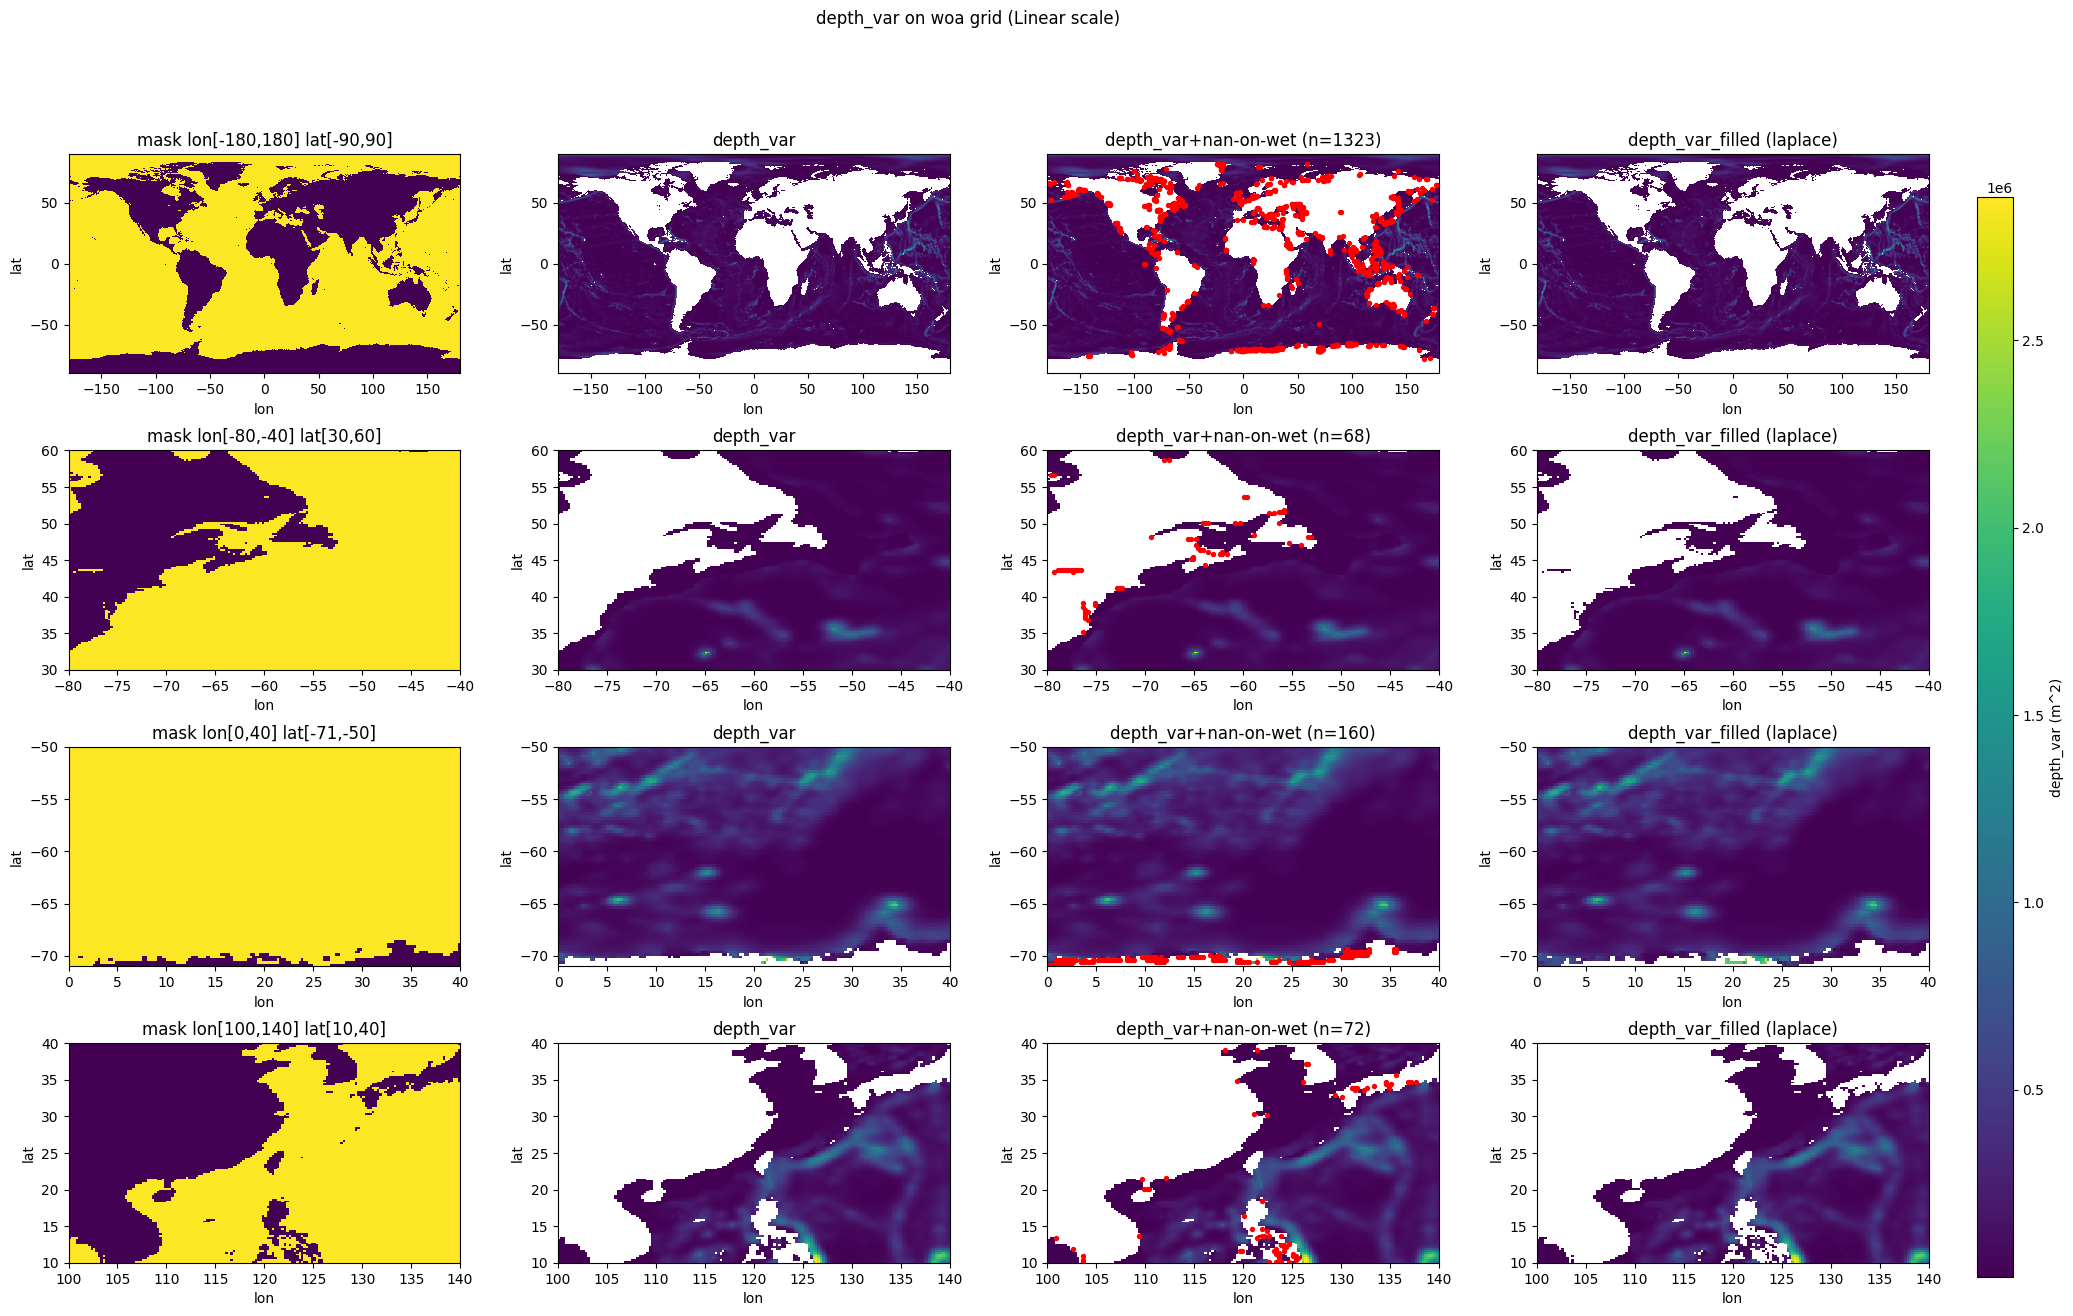

In [6]:
nrows = len(regions)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), constrained_layout=False)

last_pcm_field = None
last_pcm_filled = None

for r, (lon_min, lon_max, lat_min, lat_max) in enumerate(regions):
    sel_kwargs = dict(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    da_zoom = da.sel(**sel_kwargs)
    mask_zoom = mask_da.sel(**sel_kwargs)
    nan_zoom = (da_zoom.isnull() & mask_zoom).values

    filled_zoom = depth_var_filled.sel(**sel_kwargs)
    filled_zoom2 = depth_var_filled2.sel(**sel_kwargs)

    lon = da_zoom["lon"].values
    lat = da_zoom["lat"].values

    # indices of nan-on-wet
    jj, ii = np.where(nan_zoom)

    ax = axes[r, 0]
    pcm0 = ax.pcolormesh(lon, lat, mask_zoom.values.astype(int))
    ax.set_title(f"mask lon[{lon_min},{lon_max}] lat[{lat_min},{lat_max}]")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 1]
    last_pcm_field = ax.pcolormesh(lon, lat, da_zoom.values)
    ax.set_title("depth_var")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 2]
    ax.pcolormesh(lon, lat, da_zoom.values)
    if jj.size:
        ax.scatter(lon[ii], lat[jj], s=8, c="r")
    ax.set_title(f"depth_var+nan-on-wet (n={jj.size})")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 3]
    last_pcm_filled = ax.pcolormesh(lon, lat, filled_zoom2.values)
    ax.set_title("depth_var_filled (laplace)")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

fig.subplots_adjust(right=0.90, wspace=0.25, hspace=0.35)
fig.suptitle("depth_var on woa grid (Linear scale)")

cax1 = fig.add_axes([0.92, 0.1, 0.015, 0.75])
fig.colorbar(last_pcm_field, cax=cax1, label="depth_var (m^2)")

plt.show()

5.193099438648581e-05 4126337.7440286702


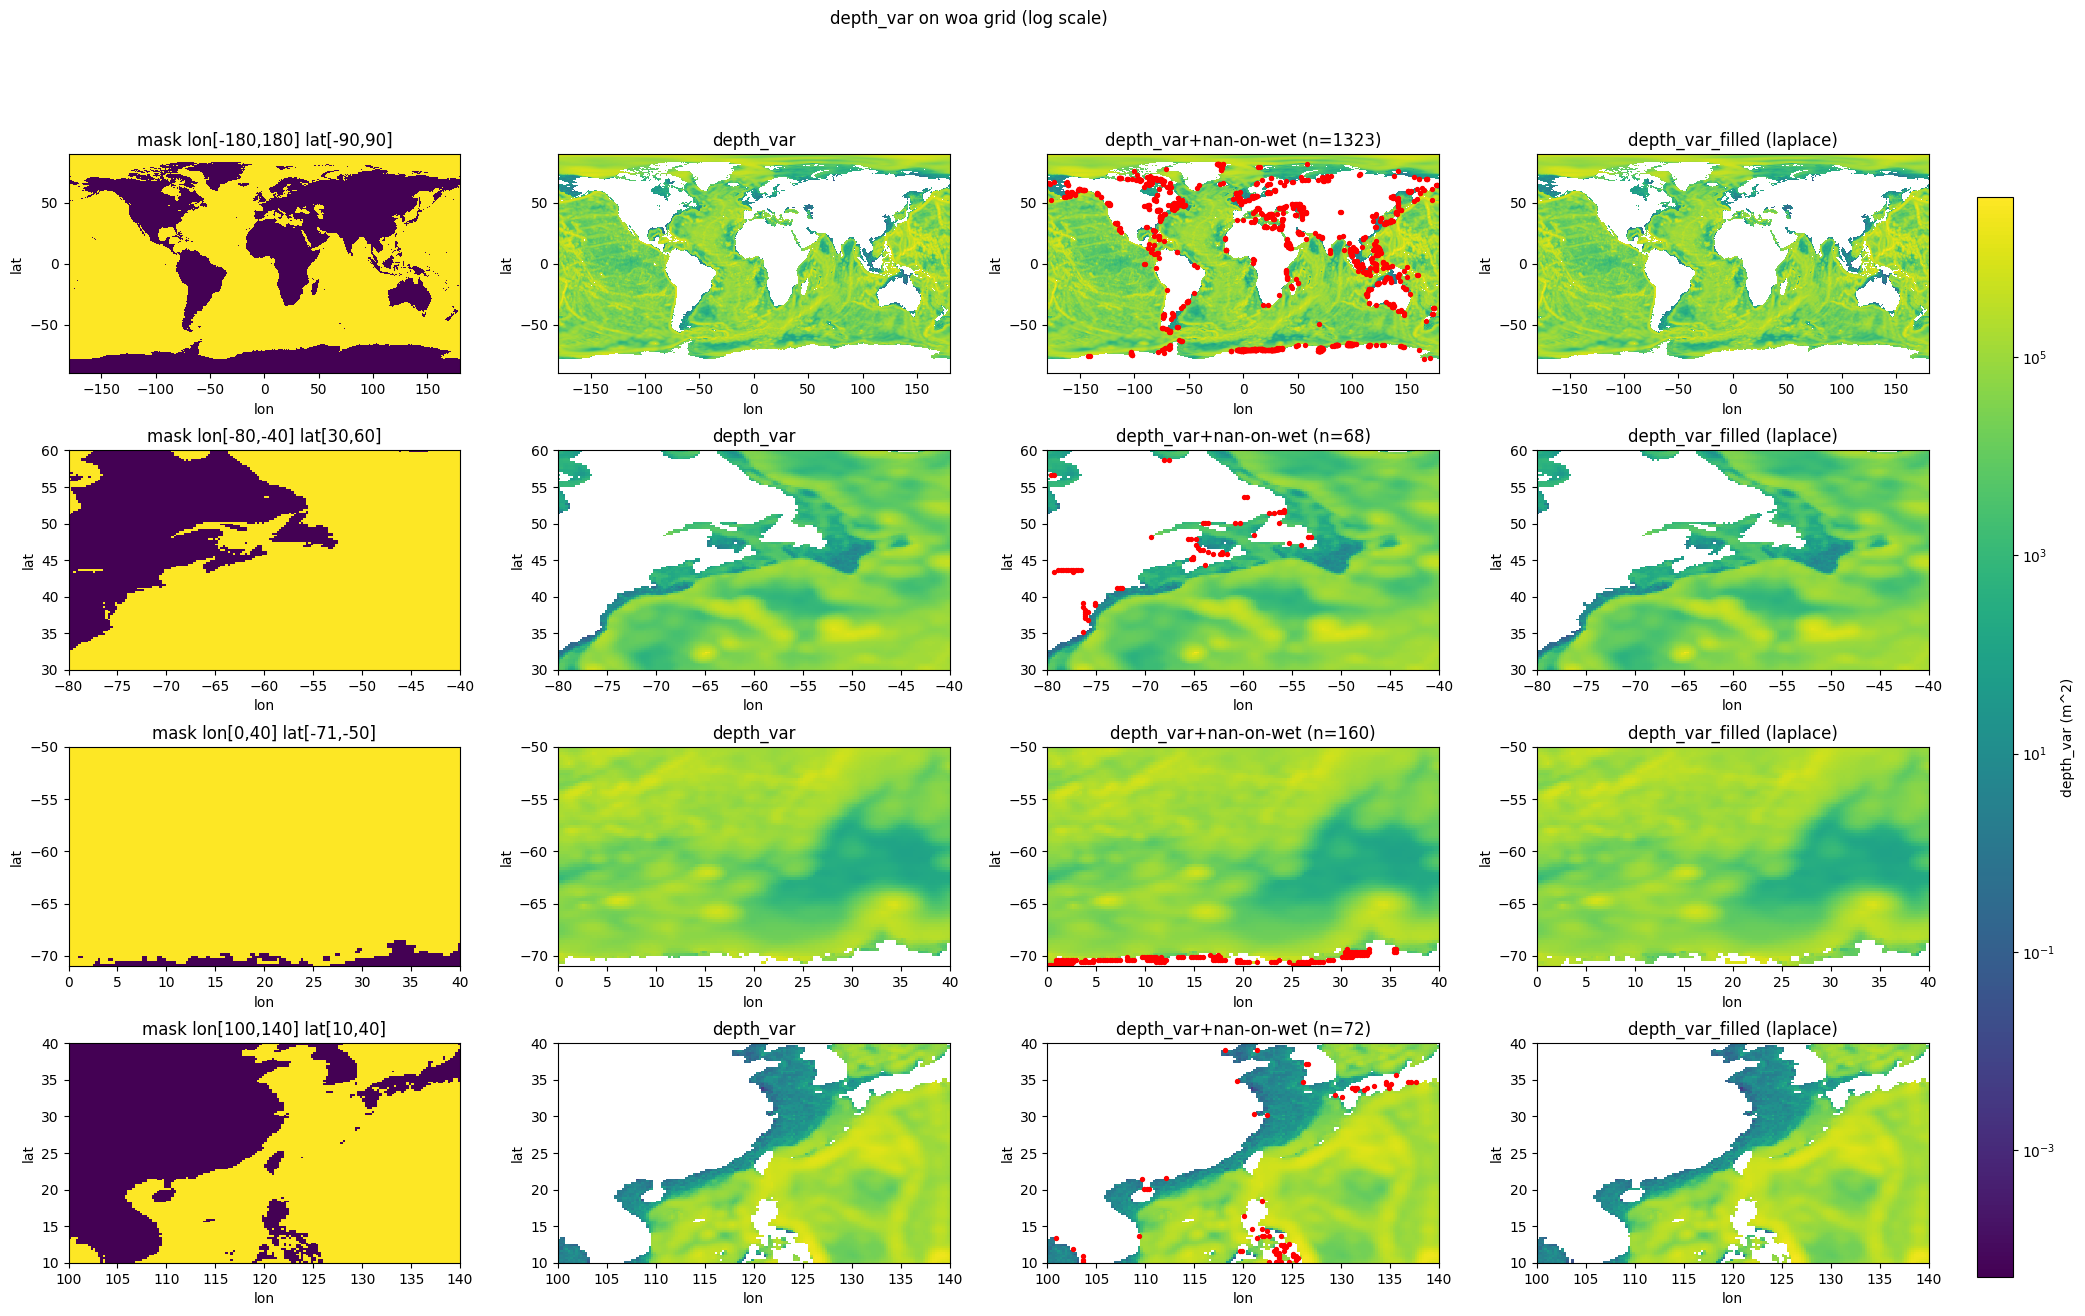

In [7]:
vmin = float(np.nanmin(da.where(da > 0)))
vmax = float(np.nanmax(da))

print(vmin, vmax)

nrows = len(regions)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), constrained_layout=False)

last_pcm_field = None
last_pcm_filled = None

for r, (lon_min, lon_max, lat_min, lat_max) in enumerate(regions):
    sel_kwargs = dict(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    da_zoom = da.sel(**sel_kwargs)
    mask_zoom = mask_da.sel(**sel_kwargs)
    nan_zoom = (da_zoom.isnull() & mask_zoom).values

    filled_zoom = depth_var_filled.sel(**sel_kwargs)
    filled_zoom2 = depth_var_filled2.sel(**sel_kwargs)

    lon = da_zoom["lon"].values
    lat = da_zoom["lat"].values

    # indices of nan-on-wet
    jj, ii = np.where(nan_zoom)

    ax = axes[r, 0]
    pcm0 = ax.pcolormesh(lon, lat, mask_zoom.values.astype(int))
    ax.set_title(f"mask lon[{lon_min},{lon_max}] lat[{lat_min},{lat_max}]")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 1]
    last_pcm_field = ax.pcolormesh(lon, lat, da_zoom.values, norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_title("depth_var")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 2]
    ax.pcolormesh(lon, lat, da_zoom.values, norm=LogNorm(vmin=vmin, vmax=vmax))
    if jj.size:
        ax.scatter(lon[ii], lat[jj], s=8, c="r")
    ax.set_title(f"depth_var+nan-on-wet (n={jj.size})")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

    ax = axes[r, 3]
    last_pcm_filled = ax.pcolormesh(lon, lat, filled_zoom2.values, norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_title("depth_var_filled (laplace)")
    ax.set_xlabel("lon"); ax.set_ylabel("lat")

fig.subplots_adjust(right=0.90, wspace=0.25, hspace=0.35)
fig.suptitle("depth_var on woa grid (log scale)")

cax1 = fig.add_axes([0.92, 0.1, 0.015, 0.75])
fig.colorbar(last_pcm_field, cax=cax1, label="depth_var (m^2)")

plt.show()

# Check values of differences

In [8]:
A = filled_zoom.values
B = filled_zoom2.values

equal = ((np.isfinite(A) & np.isfinite(B) & np.isclose(A, B, rtol=1e-12, atol=1e-14))| (np.isnan(A) & np.isnan(B)))
not_equal = ~equal
jj, ii = np.where(not_equal)
print(f"num of mismatched points: {jj.size}")
for j, i in zip(jj, ii):
    print(
        f"lon={lon[i]:.8f}, lat={lat[j]:.8f}, "
        f"A={A[j, i]}, B={B[j, i]}"
    )

num of mismatched points: 72
lon=103.62500000, lat=10.12500000, A=nan, B=0.03314947795865948
lon=122.62500000, lat=10.12500000, A=nan, B=734154.296928068
lon=123.37500000, lat=10.12500000, A=nan, B=-0.0
lon=123.87500000, lat=10.12500000, A=nan, B=-0.0
lon=124.62500000, lat=10.12500000, A=nan, B=43475.486629984836
lon=103.62500000, lat=10.37500000, A=nan, B=0.03314947795865915
lon=125.37500000, lat=10.37500000, A=nan, B=177917.44138209516
lon=123.62500000, lat=10.62500000, A=nan, B=-0.0
lon=125.37500000, lat=10.62500000, A=nan, B=137716.02953189184
lon=125.62500000, lat=10.62500000, A=nan, B=97514.6176816941
lon=103.62500000, lat=10.87500000, A=nan, B=-0.0
lon=123.62500000, lat=10.87500000, A=nan, B=-0.0
lon=125.12500000, lat=10.87500000, A=nan, B=137716.02953188485
lon=125.37500000, lat=10.87500000, A=nan, B=137716.02953188765
lon=123.37500000, lat=11.12500000, A=nan, B=-0.0
lon=123.62500000, lat=11.12500000, A=nan, B=-0.0
lon=125.12500000, lat=11.12500000, A=nan, B=137716.02953188348
